# EDA
#### Charlie Liou

Let's first use the word "Robotic" to refer to songs where an external songwriter was credited.
In this notebook, we do several exploratory analyses:

- Log-odds ratio of words in robotic songs and words in non-robotic songs
- Sentiment analysis between robotic and non-robotic songs
- Latent Dirichlet Allocation, unsupervised
- Word2Vec (when I figure out how to use Rtools with 3.5.1)
 - meanwhile, got a Python analysis going

In [4]:
# install.packages("magrittr")
# install.packages("tidytext")
# install.packages("ggplot2")
# install.packages("tm")
# install.packages("topicmodels")
# install.packages("broom")
# install.packages("devtools")
# devtools::install_github("bmschmidt/wordVectors") 
# Rtools not compatible w/ 3.5.1, MAJOR RIP

library(purrr)
library(magrittr)
library(tidyr)
library(tidytext)
library(dplyr)
library(stringr)
library(ggplot2)
library(tm)
library(topicmodels)
library(broom)


In [6]:
library = "C:\\Users\\liblabs-user\\Desktop\\song-authorship\\data"
laptop = "not yet"
desktop = "C:\\Users\\Sam\\Desktop\\song authorship\\data"

In [7]:
df <- read.csv(
    paste(desktop, "\\Billboard_2017.csv", sep = ""),
    encoding = "UTF-8",
    stringsAsFactors = FALSE)

\# of songs word appears in vs # of appearances  (song coverage)
Punctuation, etc in cleaning


To-Do list:
Charlie:
- Transition to R
- Log-odds with song counts instead of word counts **done**
- Sentiment analysis  (see Drobinson)
- Latent Dirichlet
- Surprise me?
- N-grams
- Refer to 7/20 notes


#### Personal notes

- `str_detect`
 - checks whether a token is in the string
 
 
- `str_replace_all(word, regex to replace, token to replace with)`
 - equiv to re.sub
 
 
- `unnest_wokens(word, text)`
 - word: output column name
 - text: input column that the text comes from
 
 
- `spread(key, value)`
 - takes key, all possible values and creates columns out of the values.
 - nice function

In [8]:
reg <- "([^A-Za-z\\d#@']+|'[^A-Za-z\\d#@]+)"

df_words <- df %>%
    unnest_tokens(word, Lyrics, token = "regex", pattern = reg, collapse = TRUE) %>%
    filter(!word %in% stop_words$word, 
           str_detect(word, "[a-z]"))

## Log-Odds

The log odds ratio for each word is calculated as

$$\log_2\left(\frac{\frac{\text{# in robotic}}{\text{Total robotic}}}{\frac{\text{# in non-robotic}}{\text{Total non-robotic}}}\right)$$

This means more positive ratios indicate the word appears in many more robotic songs than non-robotic songs.

We remove words with less than 9 occurences in both robotic and non-robotic songs. Should probably increase this number as we gather more data.

In [9]:
unique_df_words <- unique(df_words)

ratios <- unique_df_words %>%
    count(word, Songwriter) %>%
    filter(n > 9) %>%
    spread(Songwriter, n, fill = 0) %>%
    ungroup() %>% #what is this used for?
    mutate_each(funs((. + 1) / sum(. + 1)), -word) %>%
    mutate(logratio = log2(True / False)) %>%
    arrange(desc(logratio)) #%>%

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


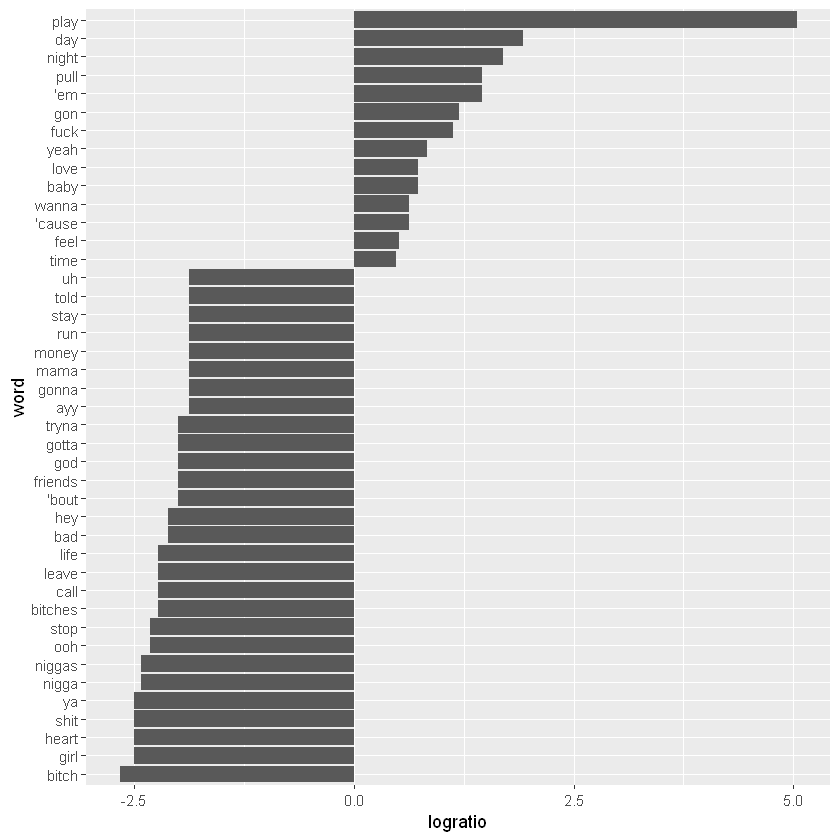

In [10]:
rbind(ratios %>% top_n(20, logratio), ratios %>% top_n(-20, logratio)) %>%
    mutate(word = reorder(word, logratio)) %>%
    ggplot(aes(word, logratio)) +
    geom_col(show.legend = FALSE) +
    coord_flip()

Key takeaways:

- Tend to use explicit language a lot more in non-robotic songs
 - what if model overfits to this?
- Verbs in robotic songs: play, pull, wanna, 'cause (because) stay. Less slang
- Verbs in non-robotic songs: call, leave, tryna, gotta, gonna. More slang
- Notice the large jumps in ratios; clearly we suffer from a bit of data sparsity.

should we stem words? clearly explicit words should be stemmed

## Sentiment Analysis

In [11]:
nrc <- sentiments %>%
    filter(lexicon == "nrc") %>%
    dplyr::select(word, sentiment)

sources <- df_words %>%
    group_by(Songwriter) %>%
    mutate(total_words = n()) %>%
    ungroup() %>%
    distinct(Name, Songwriter, total_words)

by_source_sentiment <- df_words %>%
    inner_join(nrc, by = "word") %>%
    count(sentiment, Name) %>%
    ungroup() %>%
    complete(sentiment, Name, fill = list(n = 0)) %>%
    inner_join(sources, "Name") %>%
    group_by(Songwriter, sentiment, total_words) %>%
    summarize(words = sum(n)) %>%
    ungroup()

sentiment_diff <- by_source_sentiment %>%
    group_by(sentiment) %>%
    do(tidy(poisson.test(.$words, .$total_words))) %>%
    ungroup()

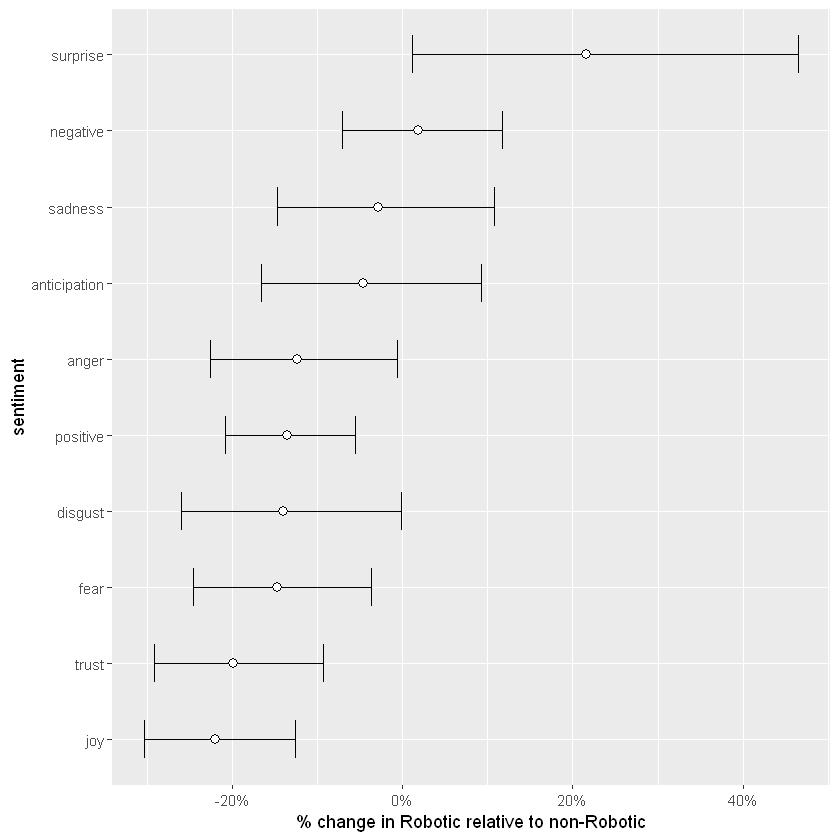

In [12]:
sentiment_diff %>%
    mutate(sentiment = reorder(sentiment, estimate)) %>%
    ggplot(aes(sentiment, estimate)) + 
    geom_errorbar(width = .5, aes(ymin = conf.low, ymax = conf.high)) +
    geom_point(shape = 21, size = 2.5, fill = "white") +
    scale_y_continuous("% change in Robotic relative to non-Robotic",
                       breaks = c(0.6, 0.8, 1, 1.2, 1.4, 1.6),
                       labels = c("-40%", "-20%", "0%", "20%", "40%", "60%")) +
    coord_flip()

- Robotic songs use around 10-20% less words related to joy, trust, and fear than non-robotic songs.
- Robotic songs use about 20% more words related to surprise than non-robotic songs.
 - However, with a correction this is most likely not going to be statistically significant.
 
Which words contributed the most to each sentiment category?
We use the previous ratios data frame but only subset words that occur at least 5 times or more.

`mutate_each()` is deprecated.
Use `mutate_all()`, `mutate_at()` or `mutate_if()` instead.
To map `funs` over a selection of variables, use `mutate_at()`


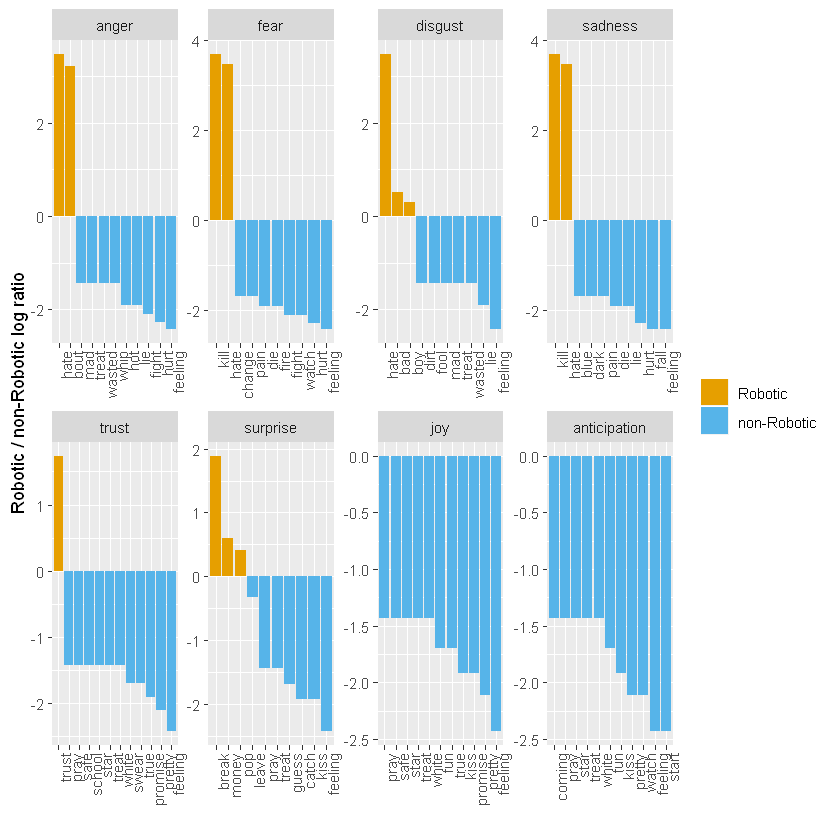

In [13]:
ratios <- unique_df_words %>%
    count(word, Songwriter) %>%
    filter(n > 3) %>%
    spread(Songwriter, n, fill = 0) %>%
    ungroup() %>% #what is this used for?
    mutate_each(funs((. + 1) / sum(. + 1)), -word) %>%
    mutate(logratio = log2(True / False)) %>%
    arrange(desc(logratio))

ratios %>%
    inner_join(nrc, by = "word") %>%
    filter(!sentiment %in% c("positive", "negative")) %>%
    mutate(sentiment = reorder(sentiment, -logratio),
           word = reorder(word, -logratio)) %>%
    group_by(sentiment) %>%
    top_n(10, abs(logratio)) %>%
    ungroup() %>%
    ggplot(aes(word, logratio, fill = logratio < 0)) +
    facet_wrap(~ sentiment, scales = "free", nrow = 2) +
    geom_bar(stat = "identity") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(x = "", y = "Robotic / non-Robotic log ratio") +
    scale_fill_manual(name = "", labels = c("Robotic", "non-Robotic"),
                    values = c("#E69F00", "#56B4E9"))

Robotic

- "Kill" and "hate" contribute the most to negative sentiments in robotic songs
- "trust" contributes the most to the Trust category


Non-robotic

- "Feeling" contributes to the most to all sentiments in non-robotic songs
- "Kiss" in surprise, joy and anticipation

Signs of data sparsity also very apparent here.

## Latent Dirichlet Allocation

We filter out words with only one occurence.

In [14]:
word_counts <- df_words %>%
    count(Name, word, sort = TRUE) %>%
    filter(n > 1) %>%
    ungroup() # do we need this?
    
word_count_matrix <- word_counts %>% cast_dtm(Name, word, n)

Warning message:
"Trying to compute distinct() for variables not found in the data:
- `row_col`, `column_col`
This is an error, but only a warning is raised for compatibility reasons.
The operation will return the input unchanged."

We start with two topics. For both topics, let us first observe the most probable terms that will be generated from each topic (terms with high $\beta$).

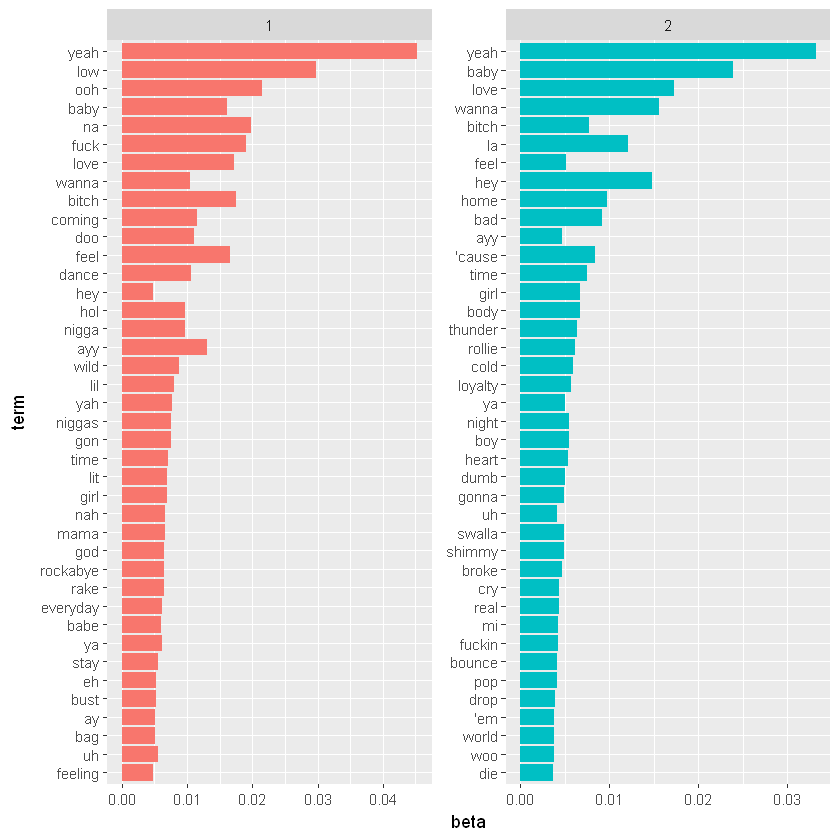

In [15]:
# create LDA object
songs_lda <- LDA(word_count_matrix, k = 2, control = list(seed = 0))
topics <- tidy(songs_lda, matrix = "beta")
    
# visualize
top_terms <- topics %>%
    group_by(topic) %>%
    top_n(40, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
    
top_terms %>%
    mutate(term = reorder(term, beta)) %>%
    ggplot(aes(term, beta, fill = factor(topic))) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~ topic, scales = "free") + # partition by topic
    coord_flip()

- Most common words in topic 1 include 'yeah', 'low', 'ooh', 'na', 'fuck', 'love' and 'wanna'. 
 - This seems to be a Rap/Hip-hop topic, possibly with sexually charged lyrics.
 
 
- The most common words in topic 2 include 'yeah', 'baby', 'love', 'wanna', 'bitch', 'la', and 'feel'. 
 - Also seems to be a Rap/Hip-hop topic
 
 
- The two words in common here are 'love' and 'yeah'. 

The key takeaway here is it seems Billboard contains many Rap/Hip-hop songs, which leads to a large class imbalance, skewing the topics. Ideally, we would have an equal number of songs per genre to reduce the effect of genre. This would lower genre as a source of variation and we would possibly have found topics that represented each genre.

We now consider words that had the greatest difference in $\beta$.

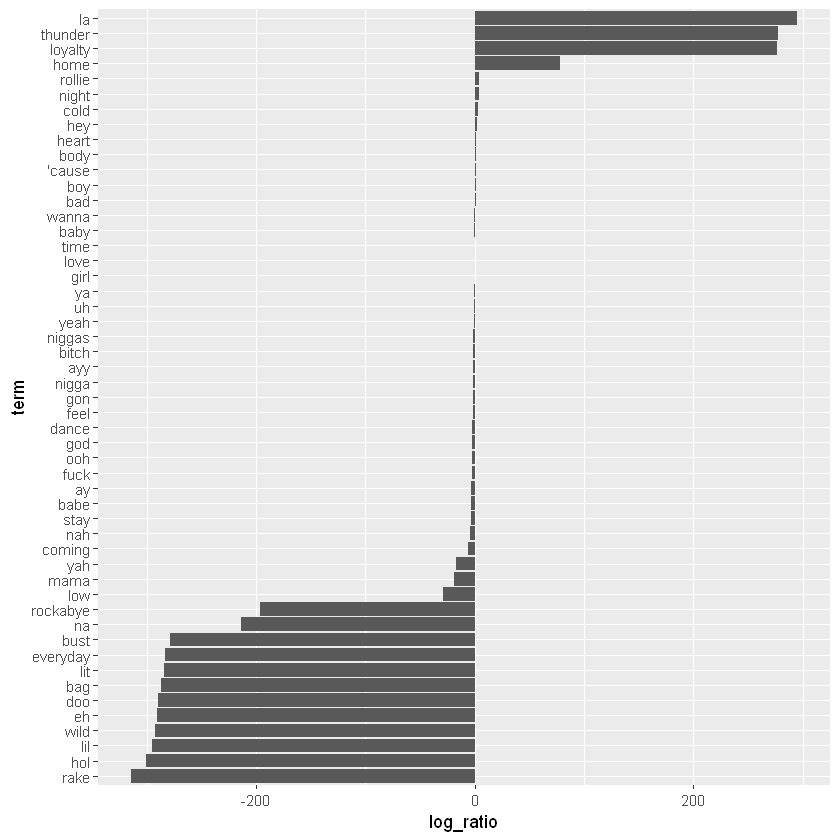

In [16]:
beta_spread <- topics %>%
    mutate(topic = paste0("topic", topic)) %>% # adds topic to each number
    spread(topic, beta) %>% # key, values w/ values for each var
    filter(topic1 > .005 | topic2 > .005) %>%
    mutate(log_ratio = log2(topic2 / topic1)) %>%
    #filter(abs(log_ratio) < 50) %>%
    arrange(-log_ratio)

# plot
beta_spread %>%
    mutate(term = reorder(term, log_ratio)) %>%
    ggplot(aes(term, log_ratio)) + 
    geom_col(show.legend = FALSE) +
    coord_flip()

- Words such as loyalty only appear in robotic songs. In fact, it only appears in "Loyalty." and "DNA.", both of which are robotic songs. Thus the extremely large and small log ratios are outliers.

In [17]:
word_counts[word_counts$word == "loyalty",]

Name,word,n
Loyalty.,loyalty,32
DNA.,loyalty,4


Just out of curiosity, what does three topics look like?

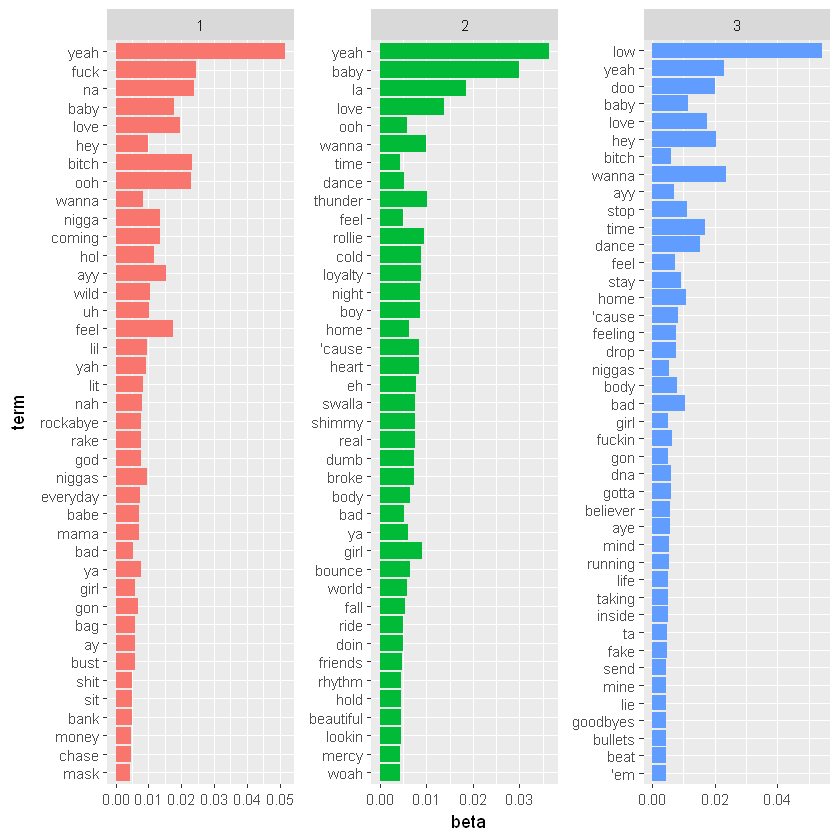

In [21]:
# create LDA object
songs_lda <- LDA(word_count_matrix, k = 3, control = list(seed = 0))
topics <- tidy(songs_lda, matrix = "beta")
    
# visualize
top_terms <- topics %>%
    group_by(topic) %>%
    top_n(40, beta) %>%
    ungroup() %>%
    arrange(topic, -beta)
    
top_terms %>%
    mutate(term = reorder(term, beta)) %>%
    ggplot(aes(term, beta, fill = factor(topic))) +
    geom_col(show.legend = FALSE) +
    facet_wrap(~ topic, scales = "free") + # partition by topic
    coord_flip()

Top words per topic are almost the same, just like with two topics. This is a sign of too many topics. 